**NER project**

**Quick remninder :** NER is a task of extracting information from the sequence of words and sentences and classifying them into pre-defined categories.

**References :**

-Juan Diego Rodriguez, Adam Caldwell and Alexander Liu “Transfer Learning for Entity Recognition of Novel Classes” 2018

-Mengdi Zhu Zheye Deng Wenhan Xiong "NEURAL CORRECTION MODEL FOR OPEN-DOMAIN NAMED ENTITY RECOGNITION"

-Our previous code from the first project

-text classification BERT tutorial :  https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/11.multi-label-text-classification-with-bert.ipynb

**Import Libraries**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
from pylab import rcParams
from sklearn.model_selection import train_test_split

**Checking the Availability of GPU in the colab Notebook using cuda library and instructing it to use GPU for processing**

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('Available:', torch.cuda.device_count())
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Available: 1


**Installing essential libraries**

**Wget :**  is a free software package for retrieving files using HTTP, HTTPS, FTP and FTPS, the most widely used Internet protocols.

**Transformers :** PyTorch-Transformers is a library of state-of-the-art pre-trained models for Natural Language Processing (NLP).

In [3]:
!pip install wget
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=6f05291d5b3e96565681a1bebb39020805830921c456b67d8af34e5e3fcef0ef
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 18.3 MB/s 
     |████████████████████████████████| 7.6 MB 55.1 MB/s 
     |████████████████████████████████| 182 kB 65.2 MB/s 


**Downloading the datasets from SPOKEN LANGUAGE SYSTEMS (SLS)**

https://groups.csail.mit.edu/sls/

**Dataset Used:** MIT Movie dataset. This Public Dataset using is an MIT Movie Corpora. It is an openly available dataset developed by
the MIT Lab for Computational Physiology, comprising of 24 labels of unstructured text sentences.

**Dataset format:** BIO / IOB format (**I**nside, **O**utside, **B**eginning) is a common tagging format for tagging tokens in a chunking task in computational linguistics (breaking text into smaller, more manageable parts, which makes the information easier to process).

In [4]:
url_train='https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio'
url_test='https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio'

In [5]:
import wget
import os

In [6]:
wget.download(url_train)

'engtrain.bio'

In [7]:
wget.download(url_test)

'engtest.bio'

**Appending all the row lines from bio format file using csvreader( ) function**

In [8]:
import csv
sentences = []
labels = []

tokens = []
token_labels = []
unique_labels = set()

with open("./engtrain.bio", newline = '') as lines:                                                                                          
  
    line_reader = csv.reader(lines, delimiter='\t')
    
    for line in line_reader:
        
        if line == []:

            sentences.append(tokens)
            labels.append(token_labels)           
    
            tokens = []
            token_labels = []        

        else: 

            tokens.append(line[1])
            token_labels.append(line[0])

            unique_labels.add(line[0])

            

**Sentences Output**

In [9]:
[  print(' '.join(sentences[i])) for i in range(10)]

what movies star bruce willis
show me films with drew barrymore from the 1980s
what movies starred both al pacino and robert deniro
find me all of the movies that starred harold ramis and bill murray
find me a movie with a quote about baseball in it
what movies have mississippi in the title
show me science fiction films directed by steven spielberg
do you have any thrillers directed by sofia coppola
what leonard cohen songs have been used in a movie
show me films elvis films set in hawaii


[None, None, None, None, None, None, None, None, None, None]

**Sample Input Sentence**

In [10]:
' '.join(sentences[1])

'show me films with drew barrymore from the 1980s'

In [11]:
pd.DataFrame({"Word":sentences[1],"Labels":labels[1]})

,Word,Labels
0,show,O
1,me,O
2,films,O
3,with,O
4,drew,B-ACTOR
5,barrymore,I-ACTOR
6,from,O
7,the,O
8,1980s,B-YEAR


In [12]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 9,775


**Preparing input text data for Feeding it into BERT model by converting and spilting the text into tokens and mapping the tokens using BertTokenizer function**

In [13]:
from transformers import BertTokenizer
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
tokenizer.encode(sentences[1])

[101, 2265, 2033, 3152, 2007, 3881, 100, 2013, 1996, 3865, 102]

In [15]:
tokenizer.decode([101, 2265, 2033, 3152, 2007, 3881, 100, 2013, 1996, 3865, 102])

'[CLS] show me films with drew [UNK] from the 1980s [SEP]'

**Calculating of length of each tokenized sentences**

BERT works with fixed-length sequences. We'll use a fixed length (max, min or median length).

In [16]:
TokenLength=[len(tokenizer.encode(' '.join(i),add_special_tokens=True)) for i in sentences]

In [17]:
print('Minimum  length: {:,} tokens'.format(min(TokenLength)))
print('Maximum length: {:,} tokens'.format(max(TokenLength)))
print('Median length: {:,} tokens'.format(int(np.median(TokenLength))))

Minimum  length: 3 tokens
Maximum length: 51 tokens
Median length: 12 tokens


From the below figure, we see that we'll be on the safe side and choose a **maximum length of 51**.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


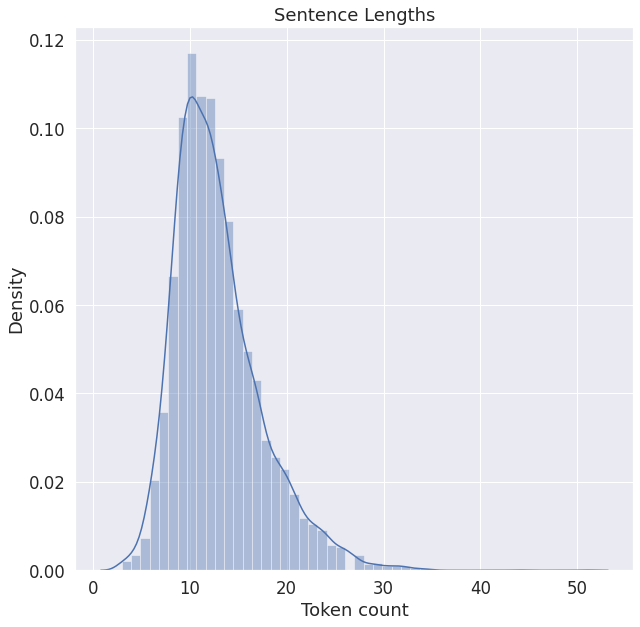

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = (10,5)
sns.distplot(TokenLength)
#plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.title('Sentence Lengths')
plt.show()

**Now we must include Padding [PAD] token in the input so every tokens should be of same length. We have selected max length of PAD token to be 55 (as max is 51)**

In [19]:
#Sample Sentence
SampleSentence=tokenizer.encode_plus(' '.join(sentences[1]), add_special_tokens = True,truncation = True,max_length = 50,padding = True,return_attention_mask = True, return_tensors = 'pt')
SampleSentence

{'input_ids': tensor([[ 101, 2265, 2033, 3152, 2007, 3881, 6287, 5974, 2013, 1996, 3865,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [20]:
#input_ids
print("\nInput Ids:",SampleSentence["input_ids"])
#attention_mask
print("\nAttention Mask:",SampleSentence["attention_mask"])


Input Ids: tensor([[ 101, 2265, 2033, 3152, 2007, 3881, 6287, 5974, 2013, 1996, 3865,  102]])

Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


**Mapping Label**

In [21]:
label_map = {}

for (i, label) in enumerate(unique_labels):
    
    # Map it to its integer
    label_map[label] = i

**Adding Attention Mask**

**Attention Mask :** It's a mask to be used if the input sequence length is smaller than the max input sequence length in the current batch. It's the mask that we typically use for attention when a batch has varying length sentences.

In [22]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

input_ids = []
attention_masks = []

for sent in sentences:

    sent_str = ' '.join(sent)
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                 
                        add_special_tokens = True,
                        truncation = True,
                        max_length = 55,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
        
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask
    attention_masks.append(encoded_dict['attention_mask'][0])

print('Original: ', sentences[24])
print('Token IDs:', input_ids[24])
print('Masks:', attention_masks[24])

Original:  ['find', 'the', 'movies', 'action', 'movies', 'directed', 'by', 'john', 'woo', 'from', 'the', '1990s']
Token IDs: tensor([  101,  2424,  1996,  5691,  2895,  5691,  2856,  2011,  2198, 15854,
         2013,  1996,  4134,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])


In [23]:
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

for (sen, orig_labels) in zip(input_ids, labels):
    
    padded_labels = []

    orig_labels_i = 0 

    for token_id in sen:

        token_id = token_id.numpy().item()

        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            padded_labels.append(null_label_id)

        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            padded_labels.append(null_label_id)

        else:
            
            label_str = orig_labels[orig_labels_i]

            padded_labels.append(label_map[label_str])

            orig_labels_i += 1

    assert(len(sen) == len(padded_labels))    

    new_labels.append(padded_labels)


In [24]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', new_labels[2])
print('\nMask:        ', attention_masks[2])


Sentence:     ['what', 'movies', 'starred', 'both', 'al', 'pacino', 'and', 'robert', 'deniro']

Labels:       ['O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'B-ACTOR', 'I-ACTOR']

BERT Tokens:  ['what', 'movies', 'starred', 'both', 'al', 'pac', '##ino', 'and', 'robert', 'den', '##iro']

Token IDs:    tensor([  101,  2054,  5691,  5652,  2119,  2632, 14397,  5740,  1998,  2728,
         7939,  9711,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])

New Labels:   [-100, 2, 2, 2, 2, 0, 6, -100, 2, 0, 6, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

**Convert the lists into PyTorch tensors using torch.stack**

In [25]:
# Concatenates a sequence of tensors along a new dimension
# [7,660  x  50].
pt_input_ids = torch.stack(input_ids, dim=0)

pt_attention_masks = torch.stack(attention_masks, dim=0)

pt_labels = torch.tensor(new_labels, dtype=torch.long)

**Split data into 90% training and 10% validation**

In [26]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training data'.format(train_size))
print('{:>5,} validation data'.format(val_size))

8,797 training data
  978 validation data


**Convert tensors into Batches for batch wise training and using RandomSampler for selecting the batch Randomly**

In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size )
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size   )

**Using BERT Model and Adam optimizer**

Model Architecture of BERT :

We are going to use a PreTrained BERT Model that consists of 12 layers of Transformers and uses Attention Mechanism (attention mask)

BERTBASE (L=12, H=768, A=12, Total Parameters=110M)

BERTLARGE (L=24, H=1024,A=16, Total Parameters=340M)

Where L=Number of Layers, H = Hidden Size and A = Number of Attention mask

Ps : L= 12 ( from 0 to 11)

In [28]:
from transformers import BertForTokenClassification, AdamW, BertConfig
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels = len(label_map) + 1, output_attentions = False, output_hidden_states = False)
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

**Hyperparameters :**

How do we come up with all hyperparameters? The BERT authors have some recommendations:

Batch size: 16, **32**

Learning rate (Adam): **5e-5**, 3e-5, 2e-5

Number of epochs: 2, 3, 4, **5**

Check author recommandations here : https://wandb.ai/jack-morris/david-vs-goliath/reports/Does-Model-Size-Matter-A-Comparison-of-BERT-and-DistilBERT--VmlldzoxMDUxNzU#:~:text=The%20BERT%20authors%20recommend%20fine,5e%2D5%2C%203e%2D5


In [29]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs 
epochs = 5

# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # learning_rate 
                  eps = 1e-8 # adam_epsilon 
                )

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [30]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

**Training Loop**

In [31]:
loss_values = []

for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    total_loss = 0
    total_acc = 0

    model.train()
    
    for step, batch in enumerate(train_dataloader):
       
        if step % 40 == 0 and not step == 0:
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))

======== Epoch 1 / 5 ========
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.43
======== Epoch 2 / 5 ========
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.18
======== Epoch 3 / 5 ========
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.13
======== Epoch 4 / 5 ========
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.09
======== Epoch 5 / 5 ========
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  

**Plot of Training Loss**

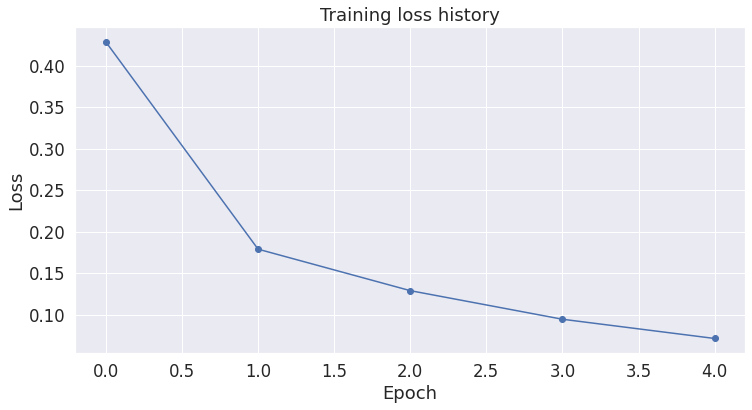

In [32]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss history")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

**Preparing the Test dataset same as training dataset for predicting the results of our Trained model**

In [33]:
import csv

# List of all sentences in the dataset.
sentences = []
labels = []

# Lists to store the current sentence.
tokens = []
token_labels = []
unique_labels = set()

with open("./engtest.bio", newline = '') as lines:                                                                                          
    
    line_reader = csv.reader(lines, delimiter='\t')
    
    for line in line_reader:
        
        if line == []:

            sentences.append(tokens)
            labels.append(token_labels)           
    
            tokens = []
            token_labels = []        

        else: 

            tokens.append(line[1])
            token_labels.append(line[0])
            unique_labels.add(line[0])

In [34]:
input_ids = []
attention_masks = []

for sent in sentences:

    sent_str = ' '.join(sent)

    encoded_dict = tokenizer.encode_plus(sent_str,add_special_tokens = True, max_length = 50,pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
       
    input_ids.append(encoded_dict['input_ids'][0])
    
    attention_masks.append(encoded_dict['attention_mask'][0])

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  ['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out', 'right', 'now']
Token IDs: tensor([  101,  2024,  2045,  2151,  2204,  6298, 22092,  2041,  2157,  2085,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [35]:
new_labels = []

null_label_id = -100

for (sen, orig_labels) in zip(input_ids, labels):
    
    padded_labels = []

    orig_labels_i = 0 

    for token_id in sen:
        
        token_id = token_id.numpy().item()

        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            padded_labels.append(null_label_id)

        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            padded_labels.append(null_label_id)

        else:
            

            label_str = orig_labels[orig_labels_i]

            padded_labels.append(label_map[label_str])

            orig_labels_i += 1

    assert(len(sen) == len(padded_labels))    

    new_labels.append(padded_labels)

In [36]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nMask:        ', attention_masks[2])
print('\nNew Labels:  ', new_labels[2])


Sentence:     ['list', 'the', 'five', 'star', 'rated', 'movies', 'starring', 'mel', 'gibson']

Labels:       ['O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR']

BERT Tokens:  ['list', 'the', 'five', 'star', 'rated', 'movies', 'starring', 'mel', 'gibson']

Token IDs:    tensor([  101,  2862,  1996,  2274,  2732,  6758,  5691,  4626, 11463,  9406,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

New Labels:   [-100, 2, 2, 17, 23, 2, 2, 2, 0, 6, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100

In [37]:
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [38]:
batch_size = 32  
prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

**Prediction on test set**

In [39]:
print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,443 test sentences...
    DONE.


**Getting F1 score**

F1 score is calculated for measuring the performance of the model

In [40]:
from sklearn.metrics import f1_score

# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels. 

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:")
print("    ", predicted_label_ids.shape) 


# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nAfter flattening the sentences, we have predictions:")
print("    ", predicted_label_ids.shape)
print("and ground truth:")
print("    ", all_true_labels.shape)


After flattening the batches, the predictions have shape:
     (2443, 50, 26)

After choosing the highest scoring label for each token:
     (2443, 50)

After flattening the sentences, we have predictions:
     (122150,)
and ground truth:
     (122150,)


In [41]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:
        
        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))


Before filtering out `null` tokens, length = 122,150
 After filtering out `null` tokens, length = 24,686


In [42]:
from sklearn.metrics import f1_score

f1 = f1_score(real_token_labels, real_token_predictions, average='micro') 

print ("F1 score: {:.2%}".format(f1))

F1 score: 94.39%


In [43]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore') 

**Display of labels**

In [44]:
print(label_map)
print(len(label_map))

{'B-ACTOR': 0, 'B-REVIEW': 1, 'O': 2, 'B-TITLE': 3, 'I-SONG': 4, 'B-PLOT': 5, 'I-ACTOR': 6, 'I-GENRE': 7, 'I-TITLE': 8, 'I-RATING': 9, 'I-REVIEW': 10, 'B-YEAR': 11, 'B-GENRE': 12, 'B-RATING': 13, 'I-CHARACTER': 14, 'B-DIRECTOR': 15, 'I-TRAILER': 16, 'B-RATINGS_AVERAGE': 17, 'I-DIRECTOR': 18, 'B-CHARACTER': 19, 'B-SONG': 20, 'I-PLOT': 21, 'I-YEAR': 22, 'I-RATINGS_AVERAGE': 23, 'B-TRAILER': 24}
25


In [45]:
print(classification_report(real_token_labels, real_token_predictions, target_names=label_map))

                   precision    recall  f1-score   support

          B-ACTOR       0.92      0.95      0.93       812
         B-REVIEW       0.44      0.27      0.33        56
                O       0.97      0.98      0.97     14929
          B-TITLE       0.89      0.89      0.89       562
           I-SONG       0.90      0.82      0.85       119
           B-PLOT       0.80      0.77      0.78       491
          I-ACTOR       0.93      0.94      0.93       862
          I-GENRE       0.84      0.75      0.79       222
          I-TITLE       0.91      0.92      0.92       856
         I-RATING       0.94      0.92      0.93       226
         I-REVIEW       0.40      0.13      0.20        45
           B-YEAR       0.95      0.96      0.96       720
          B-GENRE       0.94      0.97      0.95      1117
         B-RATING       0.96      0.97      0.97       500
      I-CHARACTER       0.56      0.59      0.58        75
       B-DIRECTOR       0.93      0.88      0.90       

The classification report shows good results for F1-score, Precision and Recall.
Also an accuracy of **94%**.
